# TP3: Problemas NP-Completos

In [14]:
import time
import random
# pip install matplotlib
from matplotlib import pyplot as plt
# pip install tabulate
from tabulate import tabulate
!pip install pulp
import pulp


Defaulting to user installation because normal site-packages is not writeable


### ¿Hitting-Set Problem está en NP?

In [15]:
#Verificamos la solucion polinomialmente
def verificar_solucion(B, C, k):
    if len(C) > k:
        return False
    satisface_Bi = [False] * len(B)

    for c in C:                      # O(#C) 
        for i in range(len(B)):
            if c in B[i]:            # O(#B[i])
                satisface_Bi[i] = True

    return all(satisface_Bi)      # O(#B)         

### Funciones auxiliares


In [16]:
# Recibe el path con el archivo a leer.
# Leemos y devolvemos un array de listas, donde cada lista posee los jugadores que piden los diferentes medios y periodistas.
def obtener_pedidos_de_la_prensa(path):
    with open(path, 'r') as archivo:
        lineas = archivo.readlines()

    pedidos_de_la_prensa = []

    for linea in lineas:
        preseleccion_linea = linea.strip().split(',')
        pedidos_de_la_prensa.append(preseleccion_linea)

    return pedidos_de_la_prensa

def obtener_todos_jugadores(pedidos_de_la_prensa):
    jugadores = set()
    for pedido in pedidos_de_la_prensa:
        for jugador in pedido:
            jugadores.add(jugador)
    return jugadores

In [17]:
# Me guardo los resultados esperados, dados por la cátedra
class Resultado:
    def __init__(self, nombre_archivo, cantidad_minima, jugadores):
        self.nombre_archivo = nombre_archivo
        self.cantidad_minima = cantidad_minima
        self.jugadores = jugadores

def obtener_resultados_esperados(nombre_archivo):
    with open(nombre_archivo, 'r') as archivo:
        contenido = archivo.read() 
    resultados = []

    # Separa el contenido en bloques
    bloques = contenido.split('\n\n')
    
    # Itera a través de cada bloque y busca "Ganancia maxima" y "Plan de entrenamiento" dentro de cada uno
    for bloque in bloques:
        nombre_archivo = ''
        cantidad_minima = 0
        jugadores = []

        lineas = bloque.split('\n')
        for linea in lineas:
            if ".txt" in linea:
                nombre_archivo = linea
            if 'Cantidad' in linea:
                cantidad_minima = int(linea.split(":")[1].split("(")[0].strip())
                jugadores_linea = linea.split("(")[1].split(")")[0]
                jugadores = [jugador.strip() for jugador in jugadores_linea.split(",")]
                resultados.append(Resultado(nombre_archivo, cantidad_minima, jugadores))

    return resultados


### Sets de datos

In [228]:
#Paths de los archivos de la catedra
path_5 = 'sets/sets de la catedra/5.txt'
path_7 = 'sets/sets de la catedra/7.txt'
path_10_pocos = 'sets/sets de la catedra/10_pocos.txt'
path_10_todos = 'sets/sets de la catedra/10_todos.txt'
path_10_varios = 'sets/sets de la catedra/10_varios.txt'
path_15 = 'sets/sets de la catedra/15.txt'
path_20 = 'sets/sets de la catedra/20.txt'
path_50 = 'sets/sets de la catedra/50.txt'
path_75 = 'sets/sets de la catedra/75.txt'
path_100 = 'sets/sets de la catedra/100.txt'
path_200 = 'sets/sets de la catedra/200.txt'
resultados_sets_catedra = 'sets/sets de la catedra/Resultados Esperados.txt'

#### Creación sets de datos propios

In [103]:
random.seed(0)

pedidos_de_prensa_max = obtener_pedidos_de_la_prensa(path_200)
universe = list(set([pedido for pedidos in pedidos_de_prensa_max for pedido in pedidos]))

def generar_instancia(universe_size, num_sets, max_set_size):
    sets = [{universe[random.randint(0, universe_size)] for _ in range(random.randint(1, max_set_size))} for _ in range(num_sets)]
    return sets

def generar_instancia_cant_por_jugador_fija(universe_size, num_sets, cant_jugadores):
    i = 0
    sets = []
    for _ in range(num_sets):
        current_set = set()
        while i < cant_jugadores:
            nuevo_jugador = universe[random.randint(0, universe_size)]
            while nuevo_jugador in current_set:
                nuevo_jugador = universe[random.randint(1, universe_size)]
            current_set.add(nuevo_jugador)
            i += 1
        i = 0
        sets.append(current_set)
    return sets

def crear_archivos(sets, nombre_archivo):
    with open(nombre_archivo, 'w') as archivo:
        for set in sets:
            archivo.write(','.join(set) + '\n')

sets_5 = generar_instancia(30, 5, 6)
sets_15 = generar_instancia(30, 15, 15)
sets_20 = generar_instancia(30, 20, 6)
sets_50 = generar_instancia(30, 50, 2)

# Testear como aumenta el tiempo de ejecucion a medida que aumenta la cantidad de jugadores por periodista
def crear_archivos_periodistas():
    for i in range(0, 30001, 150):
        sets = generar_instancia(30, i, 7)
        crear_archivos(sets, 'sets/nuestros/performance/' + str(i) + '_periodistas.txt')
       
crear_archivos(sets_5, 'sets/nuestros/5.txt')
crear_archivos(sets_15, 'sets/nuestros/15.txt')
crear_archivos(sets_20, 'sets/nuestros/20.txt')
crear_archivos(sets_50, 'sets/nuestros/50.txt')
crear_archivos_periodistas()


In [231]:
crear_archivos(generar_instancia(30,30000,7) , 'sets/nuestros/30k.txt')
crear_archivos(generar_instancia(30,300000,7) , 'sets/nuestros/300k.txt')


In [232]:
#Paths de los archivos nuestros
path_5_nuestro = 'sets/nuestros/5.txt'
path_15_nuestro = 'sets/nuestros/15.txt'
path_15_un_elemento_nuestro = 'sets/nuestros/15_un_elemento.txt'
path_20_nuestro = 'sets/nuestros/20.txt'
path_50_nuestro = 'sets/nuestros/50.txt'
path_30k_nuestro = 'sets/nuestros/30k.txt'
path_300k_nuestro = 'sets/nuestros/300k.txt'

### Obtención pedidos de la prensa

In [246]:
# Sets de la catedra
pedidos_prensa_5 = obtener_pedidos_de_la_prensa(path_5)
pedidos_prensa_7 = obtener_pedidos_de_la_prensa(path_7)
pedidos_prensa_10_pocos = obtener_pedidos_de_la_prensa(path_10_pocos)
pedidos_prensa_10_todos = obtener_pedidos_de_la_prensa(path_10_todos)
pedidos_prensa_10_varios = obtener_pedidos_de_la_prensa(path_10_varios)
pedidos_prensa_15 = obtener_pedidos_de_la_prensa(path_15)
pedidos_prensa_20 = obtener_pedidos_de_la_prensa(path_20)
pedidos_prensa_50 = obtener_pedidos_de_la_prensa(path_50)
pedidos_prensa_75 = obtener_pedidos_de_la_prensa(path_75)
pedidos_prensa_100 = obtener_pedidos_de_la_prensa(path_100)
pedidos_prensa_200 = obtener_pedidos_de_la_prensa(path_200)

# Resultados esperados
resultados_esperados = obtener_resultados_esperados(resultados_sets_catedra)
pedidos_prensa = [pedidos_prensa_5, pedidos_prensa_7, pedidos_prensa_10_pocos,pedidos_prensa_10_varios,\
                  pedidos_prensa_10_todos, pedidos_prensa_15, pedidos_prensa_20, pedidos_prensa_50,\
                  pedidos_prensa_75, pedidos_prensa_100, pedidos_prensa_200]

# Sets nuestros
pedidos_prensa_5_nuestro = obtener_pedidos_de_la_prensa(path_5_nuestro)
pedidos_prensa_15_nuestro = obtener_pedidos_de_la_prensa(path_15_nuestro)
pedidos_prensa_15_un_elemento_nuestro = obtener_pedidos_de_la_prensa(path_15_un_elemento_nuestro)
pedidos_prensa_20_nuestro = obtener_pedidos_de_la_prensa(path_20_nuestro)
pedidos_prensa_50_nuestro = obtener_pedidos_de_la_prensa(path_50_nuestro)
pedidos_prensa_30k_nuestro = obtener_pedidos_de_la_prensa(path_30k_nuestro)
pedidos_prensa_300k_nuestro = obtener_pedidos_de_la_prensa(path_300k_nuestro)

archivos_nuestros = ['5.txt', '15.txt', '15_un_elemento.txt', '20.txt', '50.txt', '30k.txt', '300k.txt']
pedidos_prensa_nuestro = [pedidos_prensa_5_nuestro, pedidos_prensa_15_nuestro, pedidos_prensa_15_un_elemento_nuestro,\
                          pedidos_prensa_20_nuestro, pedidos_prensa_50_nuestro, pedidos_prensa_30k_nuestro, pedidos_prensa_300k_nuestro]


### Función verificadora

In [22]:
#Tomamos como base la verificación del Hitting-Set Problem. Y lo ajustamos para nuestro problema.
def verificar_solucion_para_Scaloni(B, C):
    for subconjunto in B:
        if not any(elemento in C for elemento in subconjunto):
            return False
    return True 

### Solución por Backtracking

In [153]:
def satisfecho(pedido, solucion):
    return any(jugador in pedido for jugador in solucion)


def conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, indice, solucion, len_pedidos):
    cantidad_de_jugadores = len(solucion_actual)
    largo_solucion = len(solucion)
    if(cantidad_de_jugadores == len_pedidos or
       (largo_solucion > 0 and cantidad_de_jugadores == largo_solucion)):
        return False
    
    for i in range(indice, len_pedidos):
        pedido_actual = pedidos_de_prensa[i]
        if satisfecho(pedido_actual, solucion_actual):
            continue
        for jugador in pedido_actual:
            if cantidad_de_jugadores + 1 >= largo_solucion and largo_solucion != 0: 
                return False
            
            solucion_actual.append(jugador)
            cantidad_de_jugadores += 1
            
            if verificar_solucion_para_Scaloni(pedidos_de_prensa, solucion_actual):
                solucion[:] = solucion_actual
                largo_solucion = cantidad_de_jugadores
            else:        
                valido = conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i + 1, solucion, len_pedidos)
                
                if not valido:
                    solucion_actual.pop()
                    break 
            solucion_actual.pop()
            cantidad_de_jugadores -= 1

    return True 

In [154]:
def solucion_para_Scaloni(pedidos_de_prensa):
    solucion = []
    tiempo_inicial = time.time()
    conjunto_minimo_para_Scaloni(pedidos_de_prensa, [], 0, solucion, len(pedidos_de_prensa))
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion


# Ejemplo de uso
archivo_path = path_7
pedidos_de_la_prensa = obtener_pedidos_de_la_prensa(archivo_path)
solucion = solucion_para_Scaloni(pedidos_de_la_prensa)
print(solucion)

(['Mauro Zarate', 'Pezzella'], 7.748603820800781e-05)


#### Chequeo solución 

##### 1 - Usando sets de la cátedra

In [106]:
solucion_5, tiempo_ejecucion_5 = solucion_para_Scaloni(pedidos_prensa_5)
solucion_7, tiempo_ejecucion_7 = solucion_para_Scaloni(pedidos_prensa_7)
solucion_10_pocos, tiempo_ejecucion_10_pocos = solucion_para_Scaloni(pedidos_prensa_10_pocos)
solucion_10_varios, tiempo_ejecucion_10_varios = solucion_para_Scaloni(pedidos_prensa_10_varios)
solucion_10_todos, tiempo_ejecucion_10_todos = solucion_para_Scaloni(pedidos_prensa_10_todos)
solucion_15, tiempo_ejecucion_15 = solucion_para_Scaloni(pedidos_prensa_15)
solucion_20, tiempo_ejecucion_20 = solucion_para_Scaloni(pedidos_prensa_20)
solucion_50, tiempo_ejecucion_50 = solucion_para_Scaloni(pedidos_prensa_50)
solucion_75, tiempo_ejecucion_75 = solucion_para_Scaloni(pedidos_prensa_75)
solucion_100, tiempo_ejecucion_100 = solucion_para_Scaloni(pedidos_prensa_100)
solucion_200, tiempo_ejecucion_200 = solucion_para_Scaloni(pedidos_prensa_200)


In [ ]:
solucion_75, tiempo_ejecucion_75 = solucion_para_Scaloni(pedidos_prensa_75)

In [155]:
solucion_50, tiempo_ejecucion_50 = solucion_para_Scaloni(pedidos_prensa_50)
solucion_50

['Casco', 'Pity Martinez', 'Tucu Pereyra', "Barcon't", 'Palermo', 'Dybala']

In [27]:
resultados_esperados_reducido = resultados_esperados[:5]
resultados_obtenidos = [solucion_5, solucion_7, solucion_10_pocos,solucion_10_varios, solucion_10_todos]
tiempos_ejecucion = [tiempo_ejecucion_5, tiempo_ejecucion_7, tiempo_ejecucion_10_pocos, tiempo_ejecucion_10_varios, tiempo_ejecucion_10_todos]

In [28]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados = []
i = 0
for resultado_esperado in resultados_esperados_reducido:
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(resultados_obtenidos[i]) and \
    verificar_solucion_para_Scaloni(pedidos_prensa[i], resultados_obtenidos[i]) else "No"
  resultados.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(resultados_obtenidos[i]), es_correcto, tiempos_ejecucion[i]]) 
  i += 1
print(tabulate(resultados, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))

Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                5.74589e-05
7.txt                                   2                           2  Sí                                                0.000114202
10_pocos.txt                            3                           3  Sí                                                0.00314951
10_varios.txt                           6                           6  Sí                                                0.391852
10_todos.txt                           10                          10  Sí                                                2.78729


##### 2 - Usando sets propios

In [ ]:
solucion_5_nuestro = solucion_para_Scaloni(pedidos_prensa_5_nuestro)
solucion_15_nuestro = solucion_para_Scaloni(pedidos_prensa_15_nuestro)
solucion_15_un_elemento_nuestro = solucion_para_Scaloni(pedidos_prensa_15_un_elemento_nuestro)
solucion_20_nuestro = solucion_para_Scaloni(pedidos_prensa_20_nuestro)
solucion_50_nuestro = solucion_para_Scaloni(pedidos_prensa_50_nuestro)

In [ ]:
resultados_obtenidos_nuestros = [solucion_5_nuestro, solucion_15_nuestro, solucion_15_un_elemento_nuestro, solucion_20_nuestro, solucion_50_nuestro]

In [ ]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados = []
i = 0
for resultado_obtenido in resultados_obtenidos_nuestros:
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[i], resultado_obtenido[0]) else "No"
  resultados.append([archivos_nuestros[i], len(resultado_obtenido[0]), es_correcto,resultado_obtenido[1] ]) 
  i += 1
print(tabulate(resultados, headers=['Archivo', 'Cantidad minima obtenida', 'Es válida la soliución?', 'Tiempo de ejecución (s)']))

Archivo               Cantidad minima obtenida  Es válida la soliución?      Tiempo de ejecución (s)
------------------  --------------------------  -------------------------  -------------------------
5.txt                                        3  Sí                                        0.00216675
15.txt                                       5  Sí                                     7605.93
15_un_elemento.txt                          14  Sí                                        0.20838
20.txt                                       6  Sí                                     3032.28
50.txt                                      20  Sí                                     4992.13


### Solución por Programación Lineal

In [98]:
def solucion_para_Scaloni_LP(pedidos_de_prensa):
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    jugadores = obtener_todos_jugadores(pedidos_de_prensa)
    x = pulp.LpVariable.dicts("x", jugadores, lowBound=0, upBound=1, cat="Integer")
    prob += pulp.lpSum([x[i] for i in jugadores])
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    solucion = [x[i] for i in jugadores if x[i].value() == 1]
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [211]:
def arreglar_resultados(resultados):
  if isinstance(resultados[0][0], str):
    return resultados
  for resultado in resultados:
    resultado[:] = [jugador.name.replace('x_', '').replace('_', ' ') for jugador in resultado]

##### 1 - Sets de la cátedra
Chequeamos con todos los sets de la cátedra ya que a diferencia de la solución por backtracking, se puede resolver en un tiempo de ejecución razonable.

In [ ]:
solucion_5_lp, tiempo_ejecucion_5_lp = solucion_para_Scaloni_LP(pedidos_prensa_5)
solucion_7_lp, tiempo_ejecucion_7_lp = solucion_para_Scaloni_LP(pedidos_prensa_7)
solucion_10_pocos_lp, tiempo_ejecucion_10_pocos_lp = solucion_para_Scaloni_LP(pedidos_prensa_10_pocos)
solucion_10_varios_lp, tiempo_ejecucion_10_varios_lp = solucion_para_Scaloni_LP(pedidos_prensa_10_varios)
solucion_10_todos_lp, tiempo_ejecucion_10_todos_lp = solucion_para_Scaloni_LP(pedidos_prensa_10_todos)
solucion_15_lp, tiempo_ejecucion_15_lp = solucion_para_Scaloni_LP(pedidos_prensa_15)
solucion_20_lp, tiempo_ejecucion_20_lp = solucion_para_Scaloni_LP(pedidos_prensa_20)
solucion_50_lp, tiempo_ejecucion_50_lp = solucion_para_Scaloni_LP(pedidos_prensa_50)
solucion_75_lp, tiempo_ejecucion_75_lp = solucion_para_Scaloni_LP(pedidos_prensa_75)
solucion_100_lp, tiempo_ejecucion_100_lp = solucion_para_Scaloni_LP(pedidos_prensa_100)
solucion_200_lp, tiempo_ejecucion_200_lp = solucion_para_Scaloni_LP(pedidos_prensa_200)

In [236]:
resultados_obtenidos_lp = [solucion_5_lp, solucion_7_lp, solucion_10_pocos_lp, solucion_10_varios_lp, solucion_10_todos_lp,\
                        solucion_15_lp, solucion_20_lp,solucion_50_lp, solucion_75_lp, solucion_100_lp, solucion_200_lp]
arreglar_resultados(resultados_obtenidos_lp)

tiempos_ejecucion_lp = [tiempo_ejecucion_5_lp, tiempo_ejecucion_7_lp, tiempo_ejecucion_10_pocos_lp, tiempo_ejecucion_10_varios_lp,\
                      tiempo_ejecucion_10_todos_lp, tiempo_ejecucion_15_lp, tiempo_ejecucion_20_lp, tiempo_ejecucion_50_lp,\
                      tiempo_ejecucion_75_lp, tiempo_ejecucion_100_lp, tiempo_ejecucion_200_lp]

resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(resultados_obtenidos_lp[i]) and \
    verificar_solucion_para_Scaloni(pedidos_prensa[i],resultados_obtenidos_lp[i]) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(resultados_obtenidos_lp[i]), es_correcto, tiempos_ejecucion_lp[i]]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                 0.00449181
7.txt                                   2                           2  Sí                                                 0.00367999
10_pocos.txt                            3                           3  Sí                                                 0.00448871
10_varios.txt                           6                           6  Sí                                                 0.00379705
10_todos.txt                           10                          10  Sí                                                 0.00368834
15.txt                                  4                           4

##### 2 - Sets propios

In [248]:
solucion_5_lp_nuestro, tiempo_ejecucion_5_lp_nuestro = solucion_para_Scaloni_LP(pedidos_prensa_5_nuestro)
solucion_15_lp_nuestro, tiempo_ejecucion_15_lp_nuestro = solucion_para_Scaloni_LP(pedidos_prensa_15_nuestro)
solucion_15_un_elemento_lp_nuestro, tiempo_ejecucion_15_un_elemento_lp_nuestro = solucion_para_Scaloni_LP(pedidos_prensa_15_un_elemento_nuestro)
solucion_20_lp_nuestro, tiempo_ejecucion_20_lp_nuestro = solucion_para_Scaloni_LP(pedidos_prensa_20_nuestro)
solucion_50_lp_nuestro, tiempo_ejecucion_50_lp_nuestro = solucion_para_Scaloni_LP(pedidos_prensa_50_nuestro)
# Probamos con volumenes de datos mayores:
solucion_300k_lp, tiempo_ejecucion_300k_lp = solucion_para_Scaloni_LP(pedidos_prensa_300k_nuestro)
solucion_30k_lp, tiempo_ejecucion_30k_lp = solucion_para_Scaloni_LP(pedidos_prensa_30k_nuestro)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/valentinaadelsflugel/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c9f058869fa44fe0b69794c9601b54cb-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/c9f058869fa44fe0b69794c9601b54cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 70 RHS
At line 76 BOUNDS
At line 91 ENDATA
Problem MODEL has 5 rows, 14 columns and 17 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3 - 0.00 seconds
Cgl0004I processed model has 5 rows, 8 columns (8 integer (4 of which binary)) and 11 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Cleaned solution of 3
Cbc0038I Before mini branch and bound, 8 integers at bound fixed and 0 continuous of which

In [249]:
resultados_obtenidos_nuestros_lp = [solucion_5_lp_nuestro, solucion_15_lp_nuestro, solucion_15_un_elemento_lp_nuestro,\
                                              solucion_20_lp_nuestro, solucion_50_lp_nuestro, solucion_30k_lp, solucion_300k_lp]
arreglar_resultados(resultados_obtenidos_nuestros_lp)
tiempos_ejecucion_nuestros_lp = [tiempo_ejecucion_5_lp_nuestro, tiempo_ejecucion_15_lp_nuestro, tiempo_ejecucion_15_un_elemento_lp_nuestro,\
                        tiempo_ejecucion_20_lp_nuestro, tiempo_ejecucion_50_lp_nuestro, tiempo_ejecucion_30k_lp, tiempo_ejecucion_300k_lp]

In [250]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp_nuestros = []
i = 0
for resultado_obtenido in resultados_obtenidos_nuestros_lp:
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[i],resultados_obtenidos_nuestros_lp[i]) else "No"
  resultados_lp_nuestros.append([archivos_nuestros[i], len(resultados_obtenidos_nuestros_lp[i]), es_correcto, tiempos_ejecucion_lp[i]]) 
  i += 1

print(tabulate(resultados_lp_nuestros, headers=['Archivo', 'Cantidad mínima obtenida', 'Es válida?', 'Tiempo de ejecución (s)']))


Archivo               Cantidad mínima obtenida  Es válida?      Tiempo de ejecución (s)
------------------  --------------------------  ------------  -------------------------
5.txt                                        3  Sí                           0.00449181
15.txt                                       4  Sí                           0.00367999
15_un_elemento.txt                          14  Sí                           0.00448871
20.txt                                       8  Sí                           0.00379705
50.txt                                      20  Sí                           0.00368834
30k.txt                                     31  Sí                           0.00568438
300k.txt                                    31  Sí                           0.0050962


### Comparación de tiempos de ejecución según cantidad de jugadores

In [106]:
def pedidos_prensa_periodistas_performance():
    pedidos_prensa_periodistas = []
    for i in range(150, 30000,150):
        pedidos_prensa_periodistas.append(obtener_pedidos_de_la_prensa('sets/nuestros/performance/'+ str(i) + '_periodistas.txt'))
    return pedidos_prensa_periodistas

pedidos_prensa_periodistas_graficar = pedidos_prensa_periodistas_performance()

##### Algoritmo de Backtracking

In [ ]:
def obtener_soluciones(pedidos_prensa):
    soluciones = []
    i = 0
    for pedidos in pedidos_prensa:
        print(i)
        soluciones.append(solucion_para_Scaloni(pedidos))
        i += 1
    return soluciones

soluciones_periodistas = obtener_soluciones(pedidos_prensa_periodistas_graficar)

In [ ]:
# Crear dos listas separadas para soluciones y tiempos
soluciones = [len(sol[0]) for sol in soluciones_15_periodistas]
tiempos_ejecucion = [sol[1] for sol in soluciones_15_periodistas]
cantidad_jugadores = [i for i in range(1, 31)]

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(soluciones, tiempos_ejecucion)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### Algoritmo de Programacion lineal

In [ ]:
def obtener_soluciones(pedidos_prensa):
    soluciones = []
    i = 0
    for pedidos in pedidos_prensa:
        soluciones.append(solucion_para_Scaloni_LP(pedidos))
        i += 1
    return soluciones

soluciones_periodistas_lp = obtener_soluciones(pedidos_prensa_periodistas_graficar)

In [109]:
soluciones = [len(sol[0]) for sol in soluciones_periodistas_lp]
tiempos_ejecucion = [sol[1] for sol in soluciones_periodistas_lp]
cantidad_jugadores = [i for i in range(150, 30000,150)]

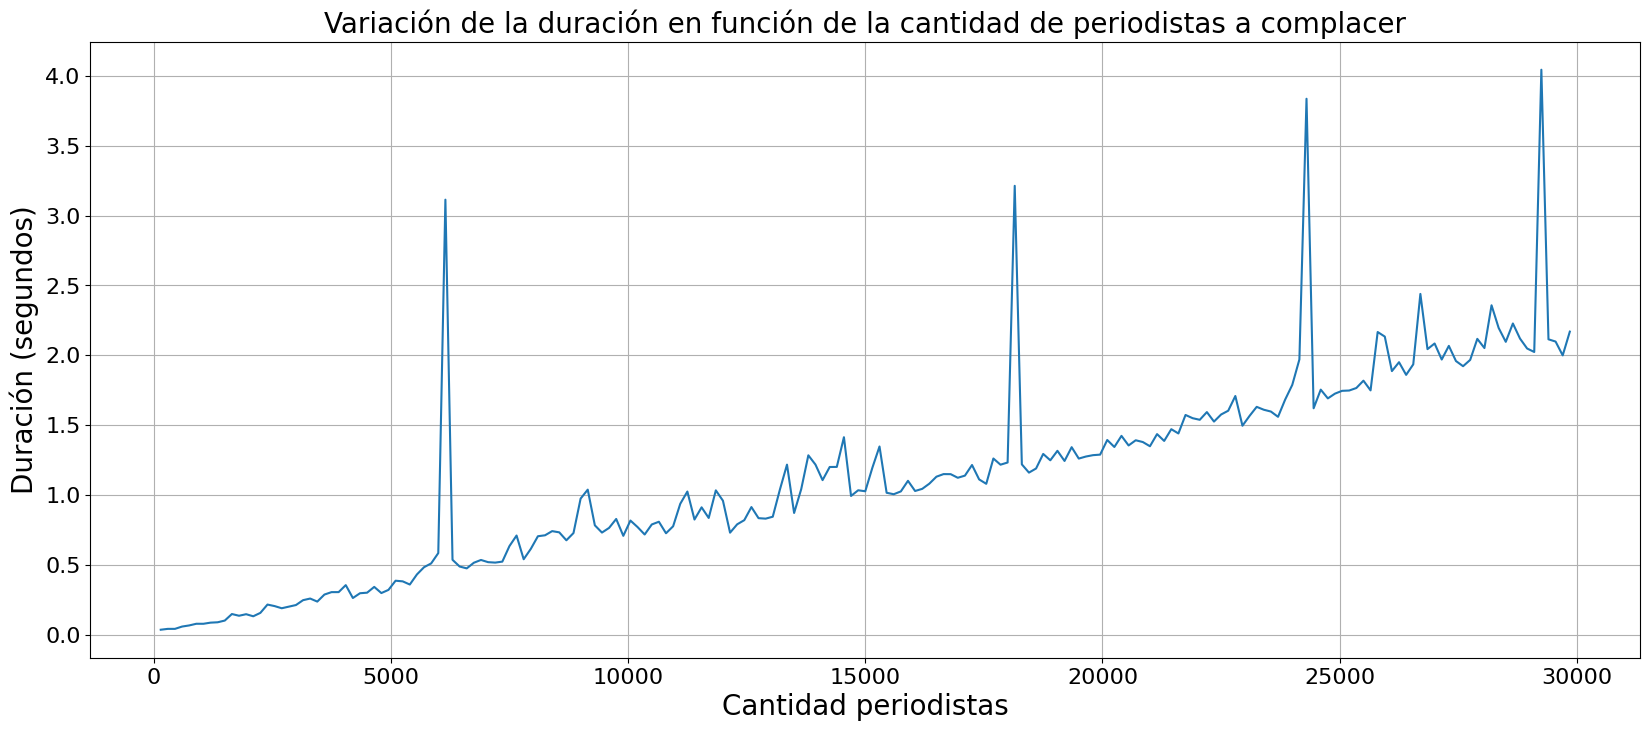

In [111]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_jugadores, tiempos_ejecucion)
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### Comparación de Backtracking y Programación Lineal

In [ ]:
##### Algoritmo de Backtracking

### Aproximación usando Programación Lineal y Redondeo

In [238]:
def solucion_para_Scaloni_LP_aprox(pedidos_de_prensa):
    b = len(max(pedidos_de_prensa))
    preseleccion = obtener_todos_jugadores(pedidos_de_prensa)
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", preseleccion, lowBound=0, upBound=1, cat="Continuous")
    prob += pulp.lpSum([x[i] for i in preseleccion])
    
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    
    # Redondeamos el resultado final
    solucion = [i for i in preseleccion if pulp.value(x[i]) >= 1/b]
    
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [240]:
solucion_5_lp, tiempo_ejecucion_5_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_5)
solucion_7_lp, tiempo_ejecucion_7_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_7)
solucion_10_pocos_lp, tiempo_ejecucion_10_pocos_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_pocos)
solucion_10_varios_lp, tiempo_ejecucion_10_varios_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_varios)
solucion_10_todos_lp, tiempo_ejecucion_10_todos_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_todos)
solucion_15_lp, tiempo_ejecucion_15_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_15)
solucion_20_lp, tiempo_ejecucion_20_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_20)
solucion_50_lp, tiempo_ejecucion_50_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_50)
solucion_75_lp, tiempo_ejecucion_75_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_75)
solucion_100_lp, tiempo_ejecucion_100_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_100)
solucion_200_lp, tiempo_ejecucion_200_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_200)

# Probamos con volumenes de datos mayores:
solucion_300k_lp, tiempo_ejecucion_300k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_300k_nuestro)
solucion_30k_lp, tiempo_ejecucion_30k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_30k_nuestro)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/valentinaadelsflugel/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d4a7a5e7b722462888a5b4ee2ad671d7-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/d4a7a5e7b722462888a5b4ee2ad671d7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 42 RHS
At line 48 BOUNDS
At line 59 ENDATA
Problem MODEL has 5 rows, 10 columns and 21 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 5 (0) rows, 8 (-2) columns and 18 (-3) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00018121093 ( 0.018121093%) - largest zero change 0
0  Obj 0 Primal inf 4.999995 (5)
5  Obj 2.0001131
Optimal - objective value 2
After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 2 - 5 iterations time 0.002, Presolve 0.00
Option for pri

In [187]:
resultados_obtenidos_lp = [solucion_5_lp, solucion_7_lp, solucion_10_pocos_lp, solucion_10_varios_lp, solucion_10_todos_lp,\
                        solucion_15_lp, solucion_20_lp,solucion_50_lp, solucion_75_lp, solucion_100_lp, solucion_200_lp, solucion_300k_lp, solucion_30k_lp]
arreglar_resultados(resultados_obtenidos_lp)

tiempos_ejecucion_lp = [tiempo_ejecucion_5_lp, tiempo_ejecucion_7_lp, tiempo_ejecucion_10_pocos_lp, tiempo_ejecucion_10_varios_lp,\
                      tiempo_ejecucion_10_todos_lp, tiempo_ejecucion_15_lp, tiempo_ejecucion_20_lp, tiempo_ejecucion_50_lp,\
                      tiempo_ejecucion_75_lp, tiempo_ejecucion_100_lp, tiempo_ejecucion_200_lp, tiempo_ejecucion_300k_lp, tiempo_ejecucion_30k_lp]

# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(resultados_obtenidos_lp[i]) and \
    verificar_solucion_para_Scaloni(pedidos_prensa[i],resultados_obtenidos_lp[i]) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(resultados_obtenidos_lp[i]), es_correcto, tiempos_ejecucion_lp[i]]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                 0.00414324
7.txt                                   2                           2  Sí                                                 0.00270391
10_pocos.txt                            3                           6  No                                                 0.00280905
10_varios.txt                           6                           6  Sí                                                 0.00326705
10_todos.txt                           10                          10  Sí                                                 0.00285363
15.txt                                  4                          11

Mostramos el resultado de los sets de datos de mayor volumen

In [241]:
print("Mínimo de jugadores para 300k datos: ", len(solucion_300k_lp))
print("Mínimo de jugadores para 30k datos: ", len(solucion_30k_lp))

Mínimo de jugadores para 300k datos:  31
Mínimo de jugadores para 30k datos:  31


Vamos a verificar si la relación hallada r(A) = b se verifica

In [190]:
def relacion_aproximacion(pedidos_de_prensa, solucion, optimo):
    b = len(max(pedidos_de_prensa))
    r = len(solucion) / optimo
    return r, b

In [206]:
from tabulate import tabulate

table_data = []
i = 0
for resultado_esperado in resultados_esperados:
    r, b = relacion_aproximacion(pedidos_prensa[i], resultados_obtenidos_lp[i], resultado_esperado.cantidad_minima)
    row = [
        resultado_esperado.nombre_archivo,
        resultado_esperado.cantidad_minima,
        len(resultados_obtenidos_lp[i]),
        b,
        r
    ]
    if r <= b:
        row.append("Sí")
    else:
        row.append("No")
    table_data.append(row)
    i += 1

headers = ["Archivo", "Óptimo", "Aproximación", "b", "r(A)", "Cumple relación de aproximación"]

print(tabulate(table_data, headers=headers))


Archivo          Óptimo    Aproximación    b     r(A)  Cumple relación de aproximación
-------------  --------  --------------  ---  -------  ---------------------------------
5.txt                 2               2    4  1        Sí
7.txt                 2               2    6  1        Sí
10_pocos.txt          3               6    7  2        Sí
10_varios.txt         6               6    3  1        Sí
10_todos.txt         10              10    4  1        Sí
15.txt                4              11    6  2.75     Sí
20.txt                5              12    7  2.4      Sí
50.txt                6              13    7  2.16667  Sí
75.txt                8              20    8  2.5      Sí
100.txt               9              17    5  1.88889  Sí
200.txt               9              24    7  2.66667  Sí


### Algoritmo Greedy

In [197]:
from collections import Counter

def ordenar_jugadores_por_apariciones(pedidos_de_la_prensa):
    jugadores = [jugador for lista in pedidos_de_la_prensa for jugador in lista]
    contador_jugadores = Counter(jugadores)
    jugadores_ordenados = sorted(contador_jugadores, key=lambda jugador: contador_jugadores[jugador], reverse=True)
    return jugadores_ordenados

def solucion_greedy(pedidos_de_la_prensa):
    tiempo = time.time()
    i = 0
    solucionado = False
    solucion = []
    jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)
    while i < len(jugadores_ordenados) and not solucionado:
        jugador_actual = jugadores_ordenados[0]
        solucion.append(jugador_actual)
        
        if verificar_solucion_para_Scaloni(pedidos_de_la_prensa, solucion):
            solucionado = True
        else:
            pedidos_de_la_prensa = [lista for lista in pedidos_de_la_prensa if jugador_actual not in lista]
            jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)
        
        i += 1
    tiempo = time.time() - tiempo
    return solucion, tiempo

In [205]:
solucion_5, tiempo_ejecucion_5 = solucion_greedy(pedidos_prensa_5)
solucion_7, tiempo_ejecucion_7 = solucion_greedy(pedidos_prensa_7)
solucion_10_pocos, tiempo_ejecucion_10_pocos = solucion_greedy(pedidos_prensa_10_pocos)
solucion_10_varios, tiempo_ejecucion_10_varios = solucion_greedy(pedidos_prensa_10_varios)
solucion_10_todos, tiempo_ejecucion_10_todos = solucion_greedy(pedidos_prensa_10_todos)
solucion_15, tiempo_ejecucion_15 = solucion_greedy(pedidos_prensa_15)
solucion_20, tiempo_ejecucion_20 = solucion_greedy(pedidos_prensa_20)
solucion_50, tiempo_ejecucion_50 = solucion_greedy(pedidos_prensa_50)
solucion_75, tiempo_ejecucion_75 = solucion_greedy(pedidos_prensa_75)
solucion_100, tiempo_ejecucion_100 = solucion_greedy(pedidos_prensa_100)
solucion_200, tiempo_ejecucion_200 = solucion_greedy(pedidos_prensa_200)